## General Workflow

### 1) Identifying Business Problem
### 2) Data Preprocessing
### 3) Exploratory Data Analysis (EDA)
### 4) Model Development & Evaluation
### 5) Model Interpretability

### 1) Identifying Business Problem

In this case, we're asked to develop a model for an organization that helps non-profit organizations to find donors. This model will be used to predict whether a donor will spend more than or equal to 30€, given that this donor receives a re-activation campaign. The model will be trained based on the previous campaign, and then validated with another data from other campaign.

The model is expected to have a good performance and high interpretability. In addition, we also have to emphasize why does implementing the model is better than random guessing campaign. In the end, the model will be used to predict potential customers for the upcoming campaign, and which customers are the most effective to reach.

### 2) Data Preprocessing

Our data consist of 5 csv files which includes the donor database, the amount of donated, and the selected donors during previous campaign

In [65]:
import sys
import subprocess
import importlib

packages = ['pandas', 'numpy','pathlib','os','glob', 'textblob']
[subprocess.check_call(['pip', 'install', pkg]) 
for pkg in packages if not importlib.util.find_spec(pkg)]

[]

In [66]:
import pandas as pd
import numpy as np

from pathlib import Path
import pathlib
import os
import glob
from numpy import where

from textblob import TextBlob

import datetime


In [3]:
# Change to working dir
os.chdir("Data")

### Load Data

In [67]:
# Loop through data folder and add all df's in a dict
data_dict={}
for txt_file in glob.glob("*.csv"):
    #list filenames
    filename = txt_file
    #create python tablenames
    df_name = str.replace(str.replace(txt_file,".csv","_raw")," ","_")
    #read files
    df_value = pd.read_csv(filename,  delimiter=",")
    #add to dict
    data_dict[df_name] = df_value

In [68]:
# Split dict into indivisual dataframes
for var in data_dict.keys():
    exec("{} = data_dict['{}']".format(var, var))

In [69]:
data_dict.keys()

dict_keys(['campaigns_raw', 'donors_raw', 'gifts_raw', 'selection_campaign_6169_raw', 'selection_campaign_7244_raw'])

### Data exploration

### Donors Data

In [70]:
# Drop 1st Column
donors = donors_raw
donors['dateOfBirth'] = pd.to_datetime(donors['dateOfBirth'])

campaign6169 = datetime.datetime(2018, 9, 4)

donors['Age'] = donors['dateOfBirth'].apply(lambda row: campaign6169.year - row.year -((campaign6169.month, campaign6169.day) < (row.month, row.day) ))
# Change ANTWERP provinces to Antwerp

donors['province'] = donors['province'].apply(lambda row: 'Antwerp' if row == 'ANTWERP' else row)

donors.head()

,Unnamed: 0,donorID,zipcode,province,region,gender,language,dateOfBirth,Age
0,0,100001,1861.0,Flemish Brabant,Flanders,F,NL,1967-12-24,50
1,1,100002,2260.0,Antwerp,Flanders,M,NL,1952-01-14,66
2,2,100003,1780.0,Flemish Brabant,Flanders,M,NL,1986-12-23,31
3,3,100004,1020.0,Brussels,Brussels,F,FR,1952-03-29,66
4,4,100005,1020.0,Brussels,Brussels,F,FR,1986-06-25,32


### Gifts Data

In [71]:
# Drop 1st Column
gifts = gifts_raw.iloc[: , 1:]
#cleaning gift
# Change date into datetime object
gifts['date'] = pd.to_datetime(gifts['date'])
#
gifts['amount'] = gifts['amount'].str.replace(',', '.')
#
gifts['amount'] = gifts['amount'].astype('float')
# Assume Independent Variable Period of 6 Months
iv_period = 180
#
in_between_period = 30



### Base Table for the training set

Some info on this table:
- The basis table is the donors that were selected for campaign 6169
- IV period of 6 months, with gap period of 7 days
- DV period is not specified. Donors are selected on the basis of their reaction to the corresponding campaign (only takes into account campaign 6169)
- Granularity is DonorID

In [72]:

#first gift table 6169 campaign
#_______________________________________________
#
selection_campaign_6169=selection_campaign_6169_raw
# Only select rows within our Independent Variable Timeline
gifts_dv_6169 = gifts[gifts['campaignID'] == 6169]
# Aggregate Data for each donors
gifts_dv_6169 = gifts_dv_6169.groupby('donorID')['amount'].agg('sum')
# Reset Index and drop 2 level columns
gifts_dv_6169 = gifts_dv_6169.reset_index()
# Rename columns
gifts_dv_6169.columns = ['donorID','total_donated_during_dv']
#
campaign6169_date = datetime.datetime(2018, 9, 4)
#
end_period = campaign6169_date - datetime.timedelta(days = in_between_period)
#
start_period = end_period - datetime.timedelta(days = iv_period)
# Only select rows within our Independent Variable Timeline
gifts_6169 = gifts[(gifts['date'] >= start_period) &  (gifts['date'] <= end_period)]
#
date_agg = gifts_6169.groupby('donorID')['date'].agg('max')

# Aggregate Data for each donors
gifts_6169 = gifts_6169.groupby('donorID')['amount'].agg(['sum', 'count'])
# Reset Index and drop 2 level columns
gifts_6169 = gifts_6169.reset_index()
#gifts_cleaned.columns = gifts_cleaned.columns.droplevel(0)

# Merge with aggregated Date
gifts_6169 = pd.merge(gifts_6169, date_agg, how='left', on='donorID')
#Rename columns
gifts_6169.columns = ['donorID','total_donated','frequency_donor', 'last_date_dono']
#
gifts_6169['Recency_dono'] = end_period - gifts_6169['last_date_dono']
#
gifts_6169['Recency_dono'] = gifts_6169['Recency_dono'].dt.days
# Build Base Table Based On the 6169 Campaign Data
gifts_6169 = pd.merge(selection_campaign_6169,gifts_6169, how='left', on='donorID')
# # Merge with iv table
gifts_6169 = pd.merge(gifts_6169, gifts_dv_6169, how='left', on='donorID')
# Merge with donor database
gifts_6169 = pd.merge(gifts_6169, donors, how='left', on='donorID')
#______________________________________
# Target Variable
gifts_6169['donated_more_than30_duringdv'] = gifts_6169['total_donated_during_dv'].apply(lambda row: 1 if row >= 30 else 0)
#______________________________________
#gender dummy
gifts_6169['p']=0
gifts_6169.loc[gifts_6169['gender']=='M','p']=0
gifts_6169.loc[gifts_6169['gender']=='F','p']=1
gifts_6169.loc[gifts_6169['gender'].isna(),'p']=969
gifts_6169['gender']=gifts_6169['p']
gifts_6169=gifts_6169.drop(['p'],axis=1)
#zip
gifts_6169.loc[gifts_6169["zipcode"].isna(),'zipcode']=969
#age
gifts_6169.loc[gifts_6169["Age"].isna(),'Age']=969
#language
gifts_6169['p']=0
gifts_6169.loc[gifts_6169['language']=='EN','p']=0
gifts_6169.loc[gifts_6169['language']=='NL','p']=1
gifts_6169.loc[gifts_6169['language']=='FR','p']=2
gifts_6169.loc[gifts_6169['language'].isna(),'p']=969
gifts_6169['language']=gifts_6169['p']
gifts_6169=gifts_6169.drop(['p'],axis=1)
#provice
gifts_6169['p']=0
gifts_6169.loc[gifts_6169['province'].isna(),['p']]=969
gifts_6169.loc[gifts_6169['province'].isna(),['province']]='nothing'
gifts_6169['province'] =gifts_6169['province'].astype('category').cat.codes
gifts_6169.loc[gifts_6169['p']==969,['province']]=969
gifts_6169.pop('p')
#region
gifts_6169['p']=0
gifts_6169.loc[gifts_6169['region'].isna(),['p']]=969
gifts_6169.loc[gifts_6169['region'].isna(),['region']]='nothing'
gifts_6169['region'] =gifts_6169['region'].astype('category').cat.codes
gifts_6169.loc[gifts_6169['p']==969,['region']]=969
gifts_6169.pop('p')
#drop variables that arent necessary for the model
gifts_6169.pop('total_donated_during_dv')
gifts_6169.pop('Unnamed: 0')
gifts_6169.pop('dateOfBirth')
gifts_6169.pop('zipcode')
#filling nans
gifts_6169['total_donated'] = gifts_6169['total_donated'].fillna(969)#(gifts_6169['total_donated'].mean()))
gifts_6169['Recency_dono'] = gifts_6169['Recency_dono'].fillna(969)#(gifts_6169['Recency_dono'].mean()))
gifts_6169['last_date_dono'] = gifts_6169['last_date_dono'].fillna(969)#(gifts_6169['last_date_dono'].median()))
gifts_6169['frequency_donor'] = gifts_6169['frequency_donor'].fillna(969)#(gifts_6169['frequency_donor'].median()))


gifts_6169

,donorID,total_donated,frequency_donor,last_date_dono,Recency_dono,province,region,gender,language,Age,donated_more_than30_duringdv
0,100001,969.0,969.0,969,969.0,3,1,1,1,50.0,0
1,100002,969.0,969.0,969,969.0,0,1,0,1,66.0,0
2,100004,969.0,969.0,969,969.0,1,0,1,2,66.0,0
3,100008,969.0,969.0,969,969.0,3,1,0,2,81.0,0
4,100009,969.0,969.0,969,969.0,1,0,0,2,86.0,0
...,...,...,...,...,...,...,...,...,...,...,...
34883,144686,969.0,969.0,969,969.0,0,1,1,1,53.0,0
34884,144687,969.0,969.0,969,969.0,5,3,0,2,47.0,0
34885,144689,100.0,1.0,2018-06-25 00:00:00,41.0,3,1,0,1,51.0,0
34886,144690,969.0,969.0,969,969.0,3,1,0,2,42.0,0


In [73]:
# #____________________________________________________
#first gift table 7244 campaign
#_______________________________________________
#
selection_campaign_7244=selection_campaign_7244_raw
# Only select rows within our Independent Variable Timeline
gifts_dv_7244 = gifts[gifts['campaignID'] == 7244]
# Aggregate Data for each donors
gifts_dv_7244 = gifts_dv_7244.groupby('donorID')['amount'].agg('sum')
# Reset Index and drop 2 level columns
gifts_dv_7244 = gifts_dv_7244.reset_index()
# Rename columns
gifts_dv_7244.columns = ['donorID','total_donated_during_dv']
#
campaign7244_date = datetime.datetime(2019, 6, 18)
#
end_period = campaign7244_date - datetime.timedelta(days = in_between_period)
#
start_period = end_period - datetime.timedelta(days = iv_period)
# Only select rows within our Independent Variable Timeline
gifts_7244 = gifts[(gifts['date'] >= start_period) &  (gifts['date'] <= end_period)]
#
date_agg = gifts_7244.groupby('donorID')['date'].agg('max')
# Aggregate Data for each donors
gifts_7244 = gifts_7244.groupby('donorID')['amount'].agg(['sum', 'count'])
# Reset Index and drop 2 level columns
gifts_7244 = gifts_7244.reset_index()
#gifts_cleaned.columns = gifts_cleaned.columns.droplevel(0)

# Merge with aggregated Date
gifts_7244 = pd.merge(gifts_7244, date_agg, how='left', on='donorID')
#Rename columns
gifts_7244.columns = ['donorID','total_donated','frequency_donor', 'last_date_dono']
#
gifts_7244['Recency_dono'] = end_period - gifts_7244['last_date_dono']
#
gifts_7244['Recency_dono'] = gifts_7244['Recency_dono'].dt.days
# Build Base Table Based On the 7244 Campaign Data
gifts_7244 = pd.merge(selection_campaign_7244,gifts_7244, how='left', on='donorID')
# # Merge with iv table
gifts_7244 = pd.merge(gifts_7244, gifts_dv_7244, how='left', on='donorID')
# Merge with donor database
gifts_7244 = pd.merge(gifts_7244, donors, how='left', on='donorID')
# #
gifts_7244['donated_more_than30_duringdv'] = gifts_7244['total_donated_during_dv'].apply(lambda row: 1 if row >= 30 else 0)

#______________________________________
#gender dummy
gifts_7244['p']=0
gifts_7244.loc[gifts_7244['gender']=='M','p']=0
gifts_7244.loc[gifts_7244['gender']=='F','p']=1
gifts_7244.loc[gifts_7244['gender'].isna(),'p']=969
gifts_7244['gender']=gifts_7244['p']
gifts_7244=gifts_7244.drop(['p'],axis=1)
#zip
gifts_7244.loc[gifts_7244["zipcode"].isna(),'zipcode']=969
#age
gifts_7244.loc[gifts_7244["Age"].isna(),'Age']=969
#language
gifts_7244['p']=0
gifts_7244.loc[gifts_7244['language']=='EN','p']=0
gifts_7244.loc[gifts_7244['language']=='NL','p']=1
gifts_7244.loc[gifts_7244['language']=='FR','p']=2
gifts_7244.loc[gifts_7244['language'].isna(),'p']=969
gifts_7244['language']=gifts_7244['p']
gifts_7244=gifts_7244.drop(['p'],axis=1)
#provice
gifts_7244['p']=0
gifts_7244.loc[gifts_7244['province'].isna(),['p']]=969
gifts_7244.loc[gifts_7244['province'].isna(),['province']]='nothing'
gifts_7244['province'] =gifts_7244['province'].astype('category').cat.codes
gifts_7244.loc[gifts_7244['p']==969,['province']]=969
gifts_7244.pop('p')
#region
gifts_7244['p']=0
gifts_7244.loc[gifts_7244['region'].isna(),['p']]=969
gifts_7244.loc[gifts_7244['region'].isna(),['region']]='nothing'
gifts_7244['region'] =gifts_7244['region'].astype('category').cat.codes
gifts_7244.loc[gifts_7244['p']==969,['region']]=969
gifts_7244.pop('p')
#drop variables that arent necessary for the model
gifts_7244.pop('total_donated_during_dv')
gifts_7244.pop('Unnamed: 0')
gifts_7244.pop('dateOfBirth')
gifts_7244.pop('zipcode')
#filling nans
gifts_7244['total_donated'] = gifts_7244['total_donated'].fillna(969)#(gifts_6169['total_donated'].mean()))
gifts_7244['Recency_dono'] = gifts_7244['Recency_dono'].fillna(969)#(gifts_6169['Recency_dono'].mean()))
gifts_7244['last_date_dono'] = gifts_7244['last_date_dono'].fillna(969)#(gifts_6169['last_date_dono'].median()))
gifts_7244['frequency_donor'] = gifts_7244['frequency_donor'].fillna(969)#(gifts_6169['frequency_donor'].median()))



gifts_7244.head()


,donorID,total_donated,frequency_donor,last_date_dono,Recency_dono,province,region,gender,language,Age,donated_more_than30_duringdv
0,100001,969.0,969.0,969,969.0,3,1,1,1,50,0
1,100002,969.0,969.0,969,969.0,0,1,0,1,66,0
2,100008,969.0,969.0,969,969.0,3,1,0,2,81,0
3,100009,969.0,969.0,969,969.0,1,0,0,2,86,0
4,100010,969.0,969.0,969,969.0,1,0,0,2,35,0


In [127]:
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import GenericUnivariateSelect, chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# Import Pandas for data manipulation purposes 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

#Logistic Regression
from sklearn.linear_model import LogisticRegression

#Decision TREES
from sklearn.tree import DecisionTreeClassifier

# regularized regression with Ridge absolute value alpha
from sklearn.linear_model import Lasso


#for confusion matrix
from sklearn.metrics import confusion_matrix
#for having clasification reports
from sklearn.metrics import classification_report
#ROC curve for analyzing Logistic regression
from sklearn.metrics import roc_curve
# Cross Validation Score
from sklearn.model_selection import cross_val_score
# Calculate AUC Score
from sklearn.metrics import roc_auc_score

#an algotithm to normalize the numbers by dividing them to thairs std
from scipy.cluster.vq import whiten

from sklearn.metrics import r2_score, accuracy_score
from scipy.stats import spearmanr, pearsonr


from sklearn.ensemble import RandomForestClassifier

In [112]:
gifts_6169=gifts_6169.dropna()

X=gifts_6169.drop(["donated_more_than30_duringdv",'last_date_dono'],axis=1)
y=gifts_6169['donated_more_than30_duringdv']

Xtrain,Xtest,ytrain,ytest=train_test_split(X,y,test_size=0.2,stratify=y)

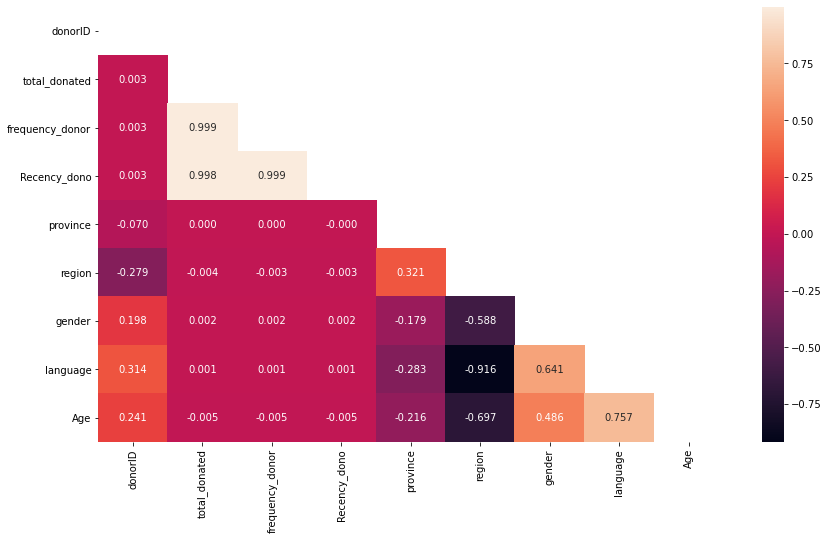

In [113]:
# Compute the correlation matrix
corr = X.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Heatmap
fig = plt.figure(figsize=(14,8))
sns.heatmap(corr, annot = True,  fmt='.3f', mask = mask)
plt.show()


In [114]:
## Instantiate a lasso regressor: lasso with normalize

lasso_norm = Lasso(alpha=0.2)

# Fit the regressor to the data
lasso_norm.fit(X,y)

# Compute and print the coefficients
lasso_coef_norm = lasso_norm.fit(X,y).coef_
print(lasso_coef_norm)

[ 1.46456920e-07  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -0.00000000e+00 -0.00000000e+00  0.00000000e+00  0.00000000e+00
  3.92796443e-04]


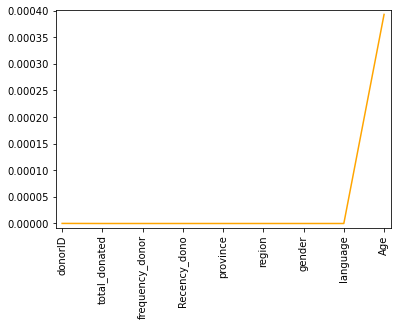

In [115]:
# Plot the coefficients
plt.plot(range(len(X.columns)), lasso_coef_norm,color='orange')
plt.xticks(range(len(X.columns)), X.columns.values, rotation=90)
plt.margins(0.02)
plt.show()

In [116]:
X_end=X.drop(["Recency_dono",'frequency_donor'],axis=1)


Xtrain,Xtest,ytrain,ytest=train_test_split(X_end,y,test_size=0.2,stratify=y,random_state=613)

In [117]:
solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
train_accuracy = np.empty(len(solvers))
test_accuracy = np.empty(len(solvers))

In [119]:
np.random.seed(613)

# Loop over different values of k
for i in range(1,len(solvers)):
    logs=LogisticRegression(solver=solvers[i])

    # Fit the classifier to the training data
    logs.fit(Xtrain,ytrain)

    #Compute accuracy on the training set
  
    train_accuracy[i] = logs.score(Xtrain, ytrain)
    
    #Compute accuracy on the training set
    test_accuracy[i] = logs.score(Xtest,ytest)

C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_sag.py:328: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


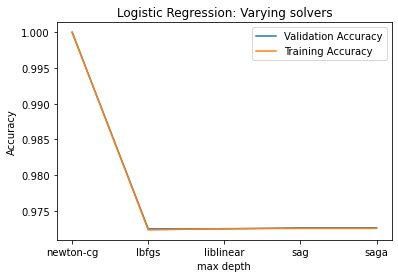

In [120]:
plt.title('Logistic Regression: Varying solvers')
plt.plot(solvers, test_accuracy, label = 'Validation Accuracy')
plt.plot(solvers, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.show()

In [108]:
lr = LogisticRegression()
lr.fit(Xtrain,ytrain)
predict_test=lr.predict(Xtest)
predict_train=lr.predict(Xtrain)
acc_train = accuracy_score(ytrain, np.round(predict_train))
acc_test = accuracy_score(ytest, np.round(predict_test))

print(f"Train:\tACC={acc_train:.4f}")
print(f"Test:\tACC={acc_test:.4f}")

Train:	ACC=0.9724
Test:	ACC=0.9723


In [121]:
print(classification_report(ytest, predict_test))
scores = cross_val_score(lr, X, y, cv=5)
scores

              precision    recall  f1-score   support

           0       0.97      1.00      0.99      6787
           1       0.00      0.00      0.00       191

    accuracy                           0.97      6978
   macro avg       0.49      0.50      0.49      6978
weighted avg       0.95      0.97      0.96      6978



C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\tools\Anaconda3\envs\py\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_i

array([0.97205503, 0.97219834, 0.97248495, 0.97248101, 0.9719077 ])

In [122]:
y_pred_prob = lr.predict_proba(Xtest)[:,1]
fpr,tpr,thresholds=roc_curve(ytest,y_pred_prob)
lr.coef_

array([[-2.13726760e-05, -2.48930278e-03, -4.67032006e-04,
        -2.66676180e-05, -1.45360705e-02, -3.49425445e-03,
         2.69519112e-02]])

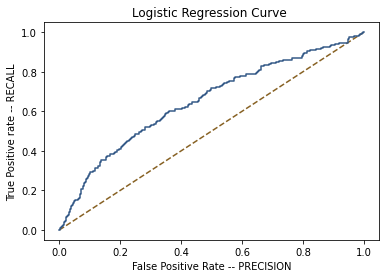

In [123]:
plt.plot([0,1],[0,1],'k--', color="#876123")
plt.plot(fpr,tpr,color='#345987')
plt.xlabel("False Positive Rate -- PRECISION")
plt.ylabel("True Positive rate -- RECALL")
plt.title("Logistic Regression Curve ")
plt.show()

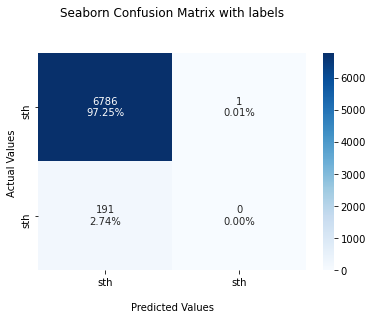

In [133]:
### Source: https://www.stackvidhya.com/plot-confusion-matrix-in-python-and-why/

#Generate the confusion matrix

cf_matrix = confusion_matrix(ytest, np.round(y_pred_prob))

group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(2,2)

# Plot correlation Matrix
ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['sth','sth'])
ax.yaxis.set_ticklabels(['sth','sth'])



## Display the visualization of the Confusion Matrix.
plt.show()

In [134]:
rfs = np.arange(1, 11)
train_accuracy = np.empty(len(rfs))
test_accuracy = np.empty(len(rfs))

In [135]:
# Loop over different values 
for i in range (0,10):
    # Setup a RF Classifier 
    rfss=RandomForestClassifier(n_estimators=100, max_depth=i+1, random_state=42)

    # Fit the classifier to the training data
    rfss.fit(Xtrain,ytrain)
    predicted_train = rfss.predict(Xtrain)
    predicted_test = rfss.predict(Xtest)

    test_accuracy[i] = accuracy_score(ytest, predicted_test)
    
    #Compute accuracy on the training set
    train_accuracy[i] = accuracy_score(ytrain,predicted_train)

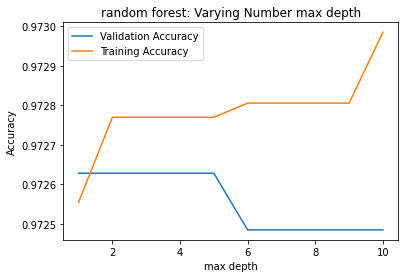

In [136]:
plt.title('random forest: Varying Number max depth')
plt.plot(rfs, test_accuracy, label = 'Validation Accuracy')
plt.plot(rfs, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('Accuracy')
plt.show()

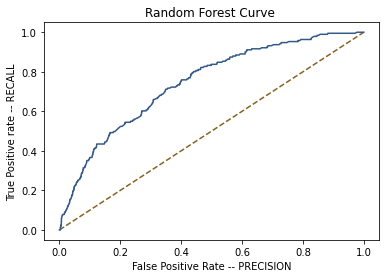

In [137]:
rf=RandomForestClassifier(n_estimators=100, max_depth=3, random_state=42)

rf = rf.fit(Xtrain,ytrain)

# Predict on the validation set
y_pred_prob = rf.predict_proba(Xtest)[:,1]

# Construct ROC 
fpr,tpr,thresholds=roc_curve(ytest,y_pred_prob)

plt.plot([0,1],[0,1],'k--', color="#876123")
plt.plot(fpr,tpr,color='#345987')
plt.xlabel("False Positive Rate -- PRECISION")
plt.ylabel("True Positive rate -- RECALL")
plt.title("Random Forest Curve ")
plt.show()